# **Lesson 05**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params

# Exercise 05.1

Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.

Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.

- Use Bohr radius units, $a_0$ for distances
- Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- How large should be the number of Monte Carlo Metropolis steps in each block?
- If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?

## Measure

In [3]:
radius_100_unif = np.loadtxt('05.1/radius_100_unif.csv', delimiter=',', skiprows=1)
radius_100_gaus = np.loadtxt('05.1/radius_100_gaus.csv', delimiter=',', skiprows=1)

radius_210_unif = np.loadtxt('05.1/radius_210_unif.csv', delimiter=',', skiprows=1)
radius_210_gaus = np.loadtxt('05.1/radius_210_gaus.csv', delimiter=',', skiprows=1)

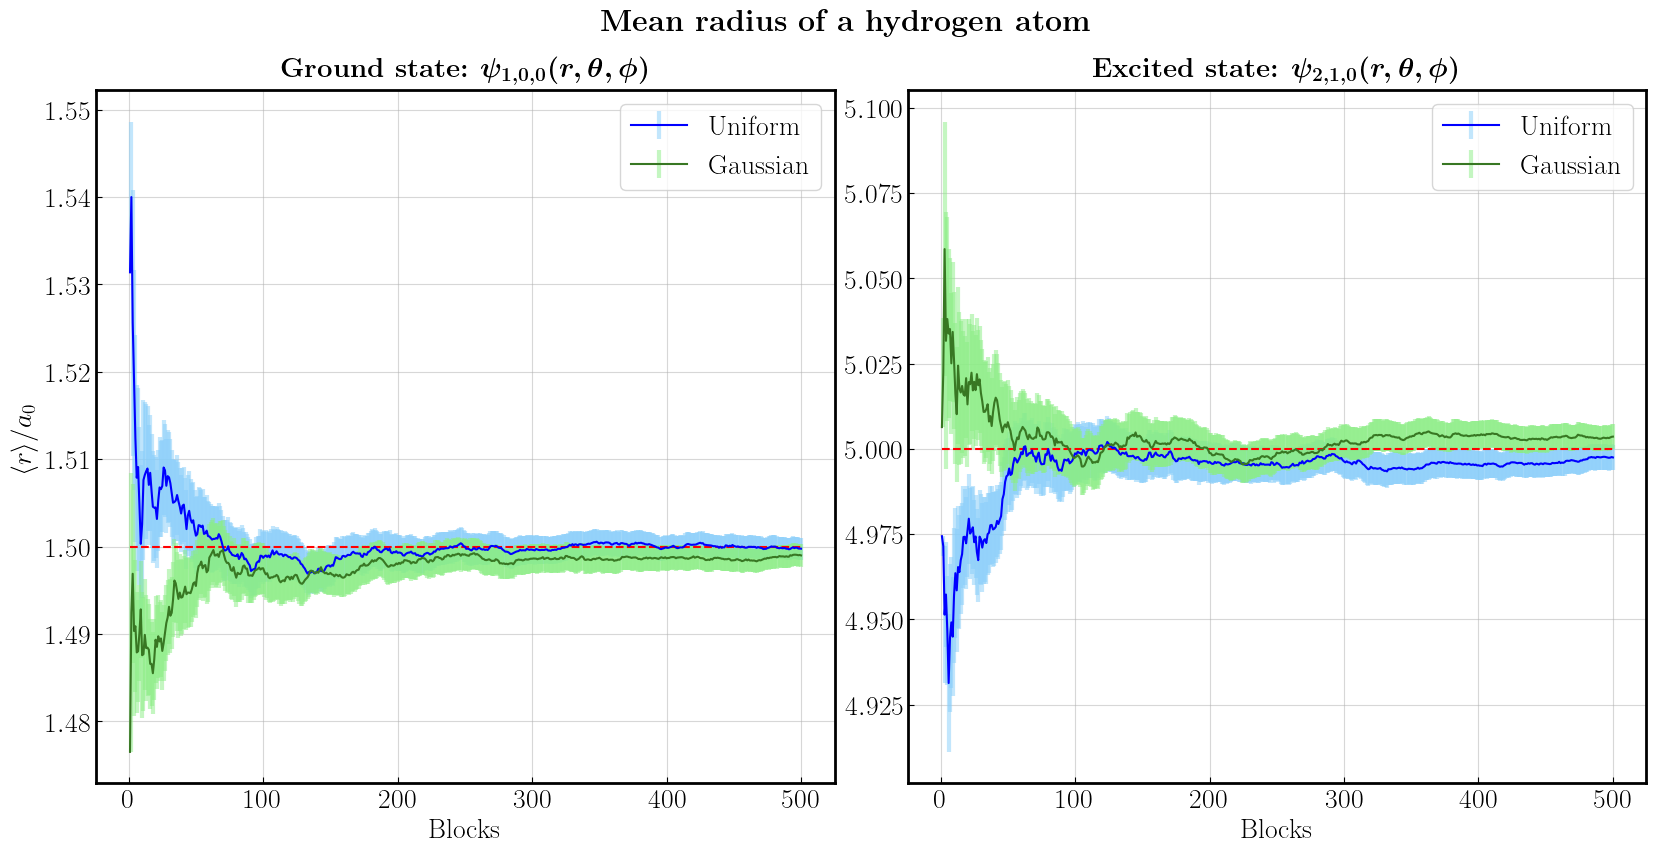

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20,9), gridspec_kw={'wspace': 0.1})


line, caplines, barlinecols = axs[0].errorbar(radius_100_unif[:,0], radius_100_unif[:,2], yerr=radius_100_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[0].errorbar(radius_100_gaus[:,0], radius_100_gaus[:,2], yerr=radius_100_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_100 = np.ones(radius_100_unif.shape[0]) * 1.5
axs[0].plot(radius_100_unif[:,0], exact_100, color='red', linestyle='--')

axs[0].set_title(r'\textbf{Ground state:} \boldmath$\psi_{1,0,0}(r, \theta, \phi)$', pad=10)
axs[0].set_xlabel('Blocks')
axs[0].set_ylabel(r'$\langle r \rangle/a_0$', labelpad=6)
axs[0].legend()


line, caplines, barlinecols = axs[1].errorbar(radius_210_unif[:,0], radius_210_unif[:,2], yerr=radius_210_unif[:,3], color='blue', ecolor='lightskyblue', alpha=0.5, elinewidth=3, label='Uniform')
line.set_alpha(1)
line, caplines, barlinecols = axs[1].errorbar(radius_210_gaus[:,0], radius_210_gaus[:,2], yerr=radius_210_gaus[:,3], color='#387723', ecolor='#8BEE84', alpha=0.5, elinewidth=3, label='Gaussian')
line.set_alpha(1)
exact_210 = np.ones(radius_210_unif.shape[0]) * 5
axs[1].plot(radius_210_unif[:,0], exact_210, color='red', linestyle='--')

axs[1].set_title(r'\textbf{Excited state:} \boldmath$\psi_{2,1,0}(r, \theta, \phi)$', pad=10)
axs[1].set_xlabel('Blocks')
axs[1].legend()


fig.suptitle(r'\textbf{Mean radius of a hydrogen atom}', y=0.97, fontsize=22)

plt.show()

## Sampling

In [5]:
sampling_100_unif = np.loadtxt('05.1/sampling_100_unif.csv', delimiter=',', skiprows=1)
sampling_100_gaus = np.loadtxt('05.1/sampling_100_gaus.csv', delimiter=',', skiprows=1)

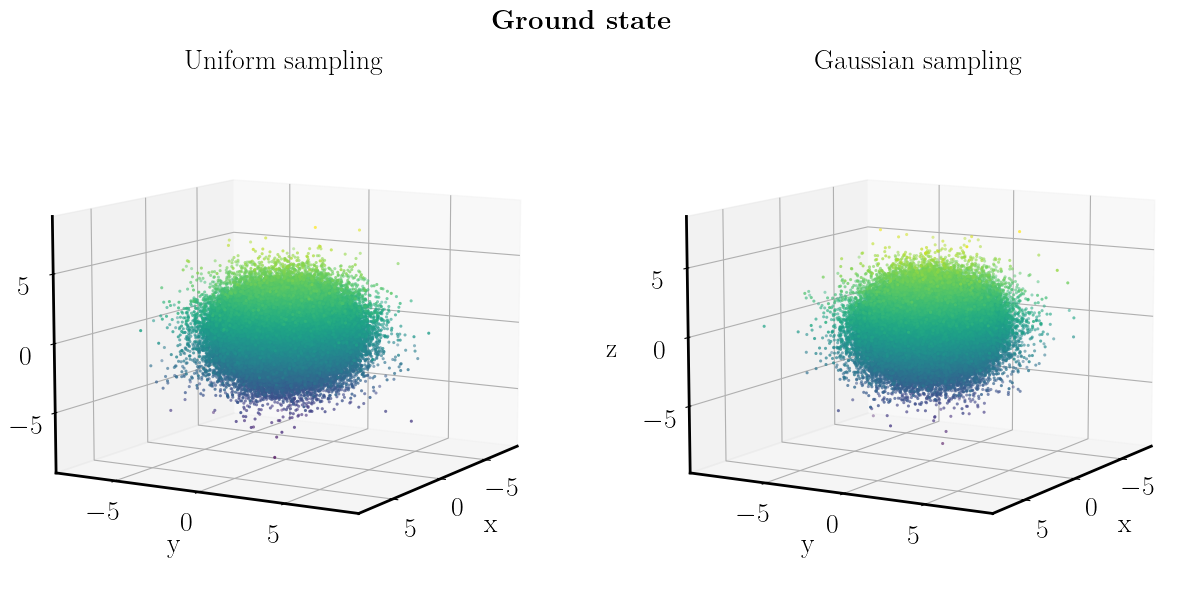

In [6]:
fig = plt.figure(figsize = (15,7))
fig.suptitle(r'\textbf{Ground state}', y=0.97, fontsize=20)
step = 10

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampling_100_unif[::step,0], sampling_100_unif[::step,1], sampling_100_unif[::step,2], marker='.', c=sampling_100_unif[::step,2], edgecolor='none')
ax.view_init(10, 30)

ax.set_title('Uniform sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampling_100_gaus[::step,0], sampling_100_gaus[::step,1], sampling_100_gaus[::step,2], marker='.', c=sampling_100_gaus[::step,2], edgecolor='none')
ax.view_init(10, 30)

ax.set_title('Gaussian sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()

In [7]:
sampling_210_unif = np.loadtxt('05.1/sampling_210_unif.csv', delimiter=',', skiprows=1)
sampling_210_gaus = np.loadtxt('05.1/sampling_210_gaus.csv', delimiter=',', skiprows=1)

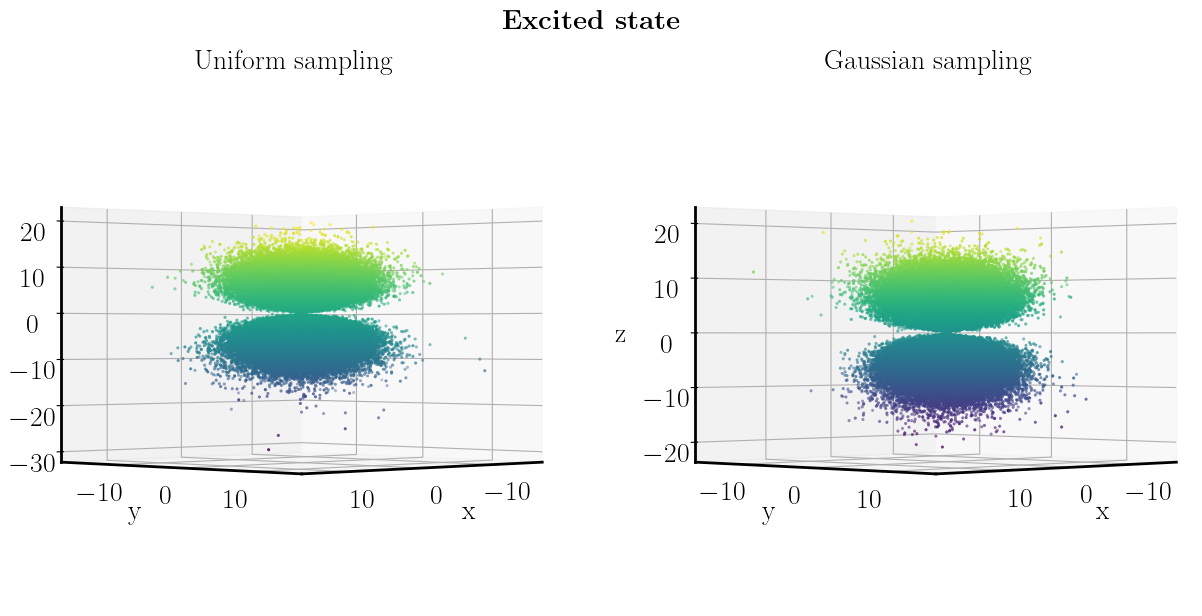

In [8]:
fig = plt.figure(figsize = (15,7))
fig.suptitle(r'\textbf{Excited state}', y=0.97, fontsize=20)
step = 10

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampling_210_unif[::step,0], sampling_210_unif[::step,1], sampling_210_unif[::step,2], marker='.', c=sampling_210_unif[::step,2], edgecolor='none')
ax.view_init(0, 45)

ax.set_title('Uniform sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampling_210_gaus[::step,0], sampling_210_gaus[::step,1], sampling_210_gaus[::step,2], marker='.', c=sampling_210_gaus[::step,2], edgecolor='none')
ax.view_init(0, 45)

ax.set_title('Gaussian sampling')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()

## Equilibration far from the origin

In [9]:
sampl_far_100_unif = np.loadtxt('05.1/sampl_far_100_unif.csv', delimiter=',', skiprows=1)
sampl_far_210_unif = np.loadtxt('05.1/sampl_far_210_unif.csv', delimiter=',', skiprows=1)

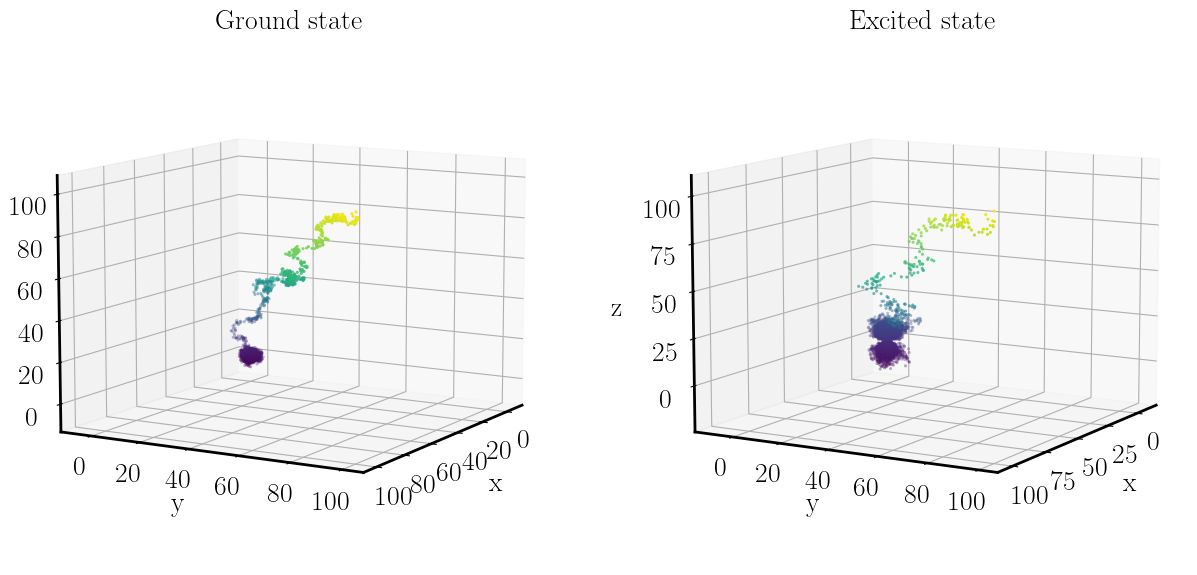

In [10]:
fig = plt.figure(figsize = (15,7))
max = int(1e4)
step = 1

ax = fig.add_subplot(1, 2, 1, projection = '3d')
ax.scatter(sampl_far_100_unif[:max:step,0], sampl_far_100_unif[:max:step,1], sampl_far_100_unif[:max:step,2], marker='.', c=sampl_far_100_unif[:max:step,2], edgecolors='none')
ax.view_init(10, 30)

ax.set_title('Ground state')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

ax = fig.add_subplot(1, 2, 2, projection = '3d')
ax.scatter(sampl_far_210_unif[:max:step,0], sampl_far_210_unif[:max:step,1], sampl_far_210_unif[:max:step,2], marker='.', c=sampl_far_210_unif[:max:step,2], edgecolors='none')
ax.view_init(10, 30)

ax.set_title('Excited state')
ax.set_xlabel('x', labelpad=10)
ax.set_ylabel('y', labelpad=10)
ax.set_zlabel('z', labelpad=10)

plt.show()